In [33]:
%load_ext autoreload
%autoreload 2
# import pyroSAR
from pyroSAR.snap.auxil import Workflow, gpt, groupbyWorkers, parse_recipe, parse_node
from s1pro.auxils import get_burst_geometry
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
infiles = ['/data/S1/S1A_IW_SLC__1SDV_20230826T180527_20230826T180554_050050_0605B2_E768.zip',
           '/data/S1/S1A_IW_SLC__1SDV_20230814T180526_20230814T180553_049875_05FFB4_7D92.zip']
outdir = '/data/res/'
aoi_path = '/data/aoi_bretagne.geojson'
# graph_path = '../graph/TOPSAR Coreg Interferogram IW2 to GeoTiff.xml'
# graph_path = '../graph/TOPSAR Coreg Coherence VV IW2 to GeoTiff.xml'
graph_path = '../graph/TOPSAR_coh_geocode_IW_to_geotiff.xml'

In [39]:
# let's find what iw and bursts intersect AOI
df_geo = get_burst_geometry(infiles[0], 
                   target_subswaths=['IW1', 'IW2','IW3'], 
                   polarization='VV')
aoi = gpd.read_file(aoi_path)

In [40]:
df_sel = df_geo[df_geo.intersects(aoi.geometry[0])]
unique_subswaths = df_sel['subswath'].unique()

In [44]:
wfl = Workflow(graph_path)
wfl['Read'].parameters['file'] = infiles[0]
wfl['Read(2)'].parameters['file'] = infiles[1]
for subswath in unique_subswaths[1:]:
    print(f"Subswath {subswath}, bursts {df_sel[df_sel['subswath']==subswath]['burst'].values}")
    wfl['TOPSAR-Split'].parameters['subswath'] = subswath
    wfl['TOPSAR-Split(2)'].parameters['subswath'] = subswath
    bursts = df_sel[df_sel['subswath']==subswath]['burst'].values
    burst_min = bursts.min()
    burst_max = bursts.max()
    wfl['TOPSAR-Split'].parameters['firstBurstIndex'] = burst_min
    wfl['TOPSAR-Split'].parameters['lastBurstIndex'] = burst_max
    wfl['TOPSAR-Split(2)'].parameters['firstBurstIndex'] = burst_min
    wfl['TOPSAR-Split(2)'].parameters['lastBurstIndex'] = burst_max
    # wfl['Write'].parameters['file'] = f"{outdir}/{subswath}_IFG.tif"
    wfl['Write'].parameters['file'] = f"{outdir}/{subswath}_COH_geo.tif"
    wfl.write('/tmp/graph.xml')
    grp = groupbyWorkers('/tmp/graph.xml', n=1)
    gpt('/tmp/graph.xml', groups=grp, tmpdir='/data/tmp/')

# if several IW are present, create a merge graph
##create workflow for merging
if len(unique_subswaths) > 1:
    workflow_tpm = parse_recipe("blank")

    read1 = parse_node('Read')
    read1.parameters['file'] = tmp_fps[0]
    workflow_tpm.insert_node(read1)
    ##handling multiple vs single IW
    if len(tmp_fps) > 1:
        readers = [read1.id]

        for t in range(1, len(tmp_fps)):
            readn = parse_node('Read')
            readn.parameters['file'] = tmp_fps[t]
            workflow_tpm.insert_node(readn, before= read1.id, resetSuccessorSource=False)
            readers.append(readn.id)

        tpm=parse_node("TOPSAR-Merge")
        tpm.parameters["selectedPolarisations"]= p

        workflow_tpm.insert_node(tpm, before=readers)
        last_id= tpm.id

Subswath IW3, bursts [4 5 6 7]


In [42]:
import rasterio as rio

# with rio.open(f"{outdir}/{subswath}_IFG.tif") as ds:
# with rio.open(f"{outdir}/{subswath}_COH.tif") as ds:
with rio.open(f"{outdir}/{subswath}_COH_geo.tif") as ds:
    print(ds.profile)
    img = ds.read(1)
    # img = ds.read(3)
    # re = ds.read(1)
    # im = ds.read(2)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6132, 'height': 4967, 'count': 1, 'crs': CRS.from_epsg(32633), 'transform': Affine(20.0, 0.0, -933398.0840116986,
       0.0, -20.0, 5543892.955377446), 'blockxsize': 288, 'blockysize': 560, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


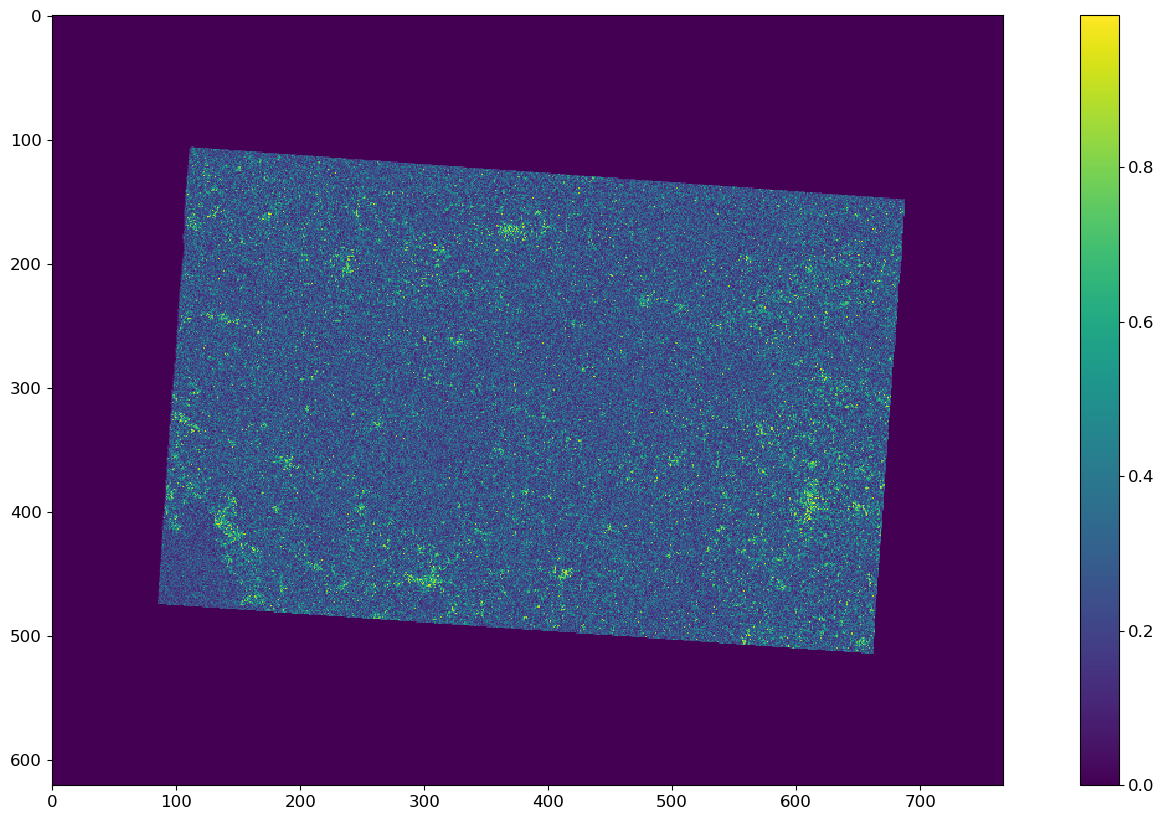

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(img[::8,::8], interpolation='nearest')#, vmin=0, vmax=100000)
plt.colorbar()